In [42]:
from importlib import reload
from load_cluster_data import load_cluster_data
from pca_kmeans_init import pca_kmeans_init
from betabinomo_mix_singlecells import *
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)
import torch
import sklearn.manifold 
import plotnine as p9
import time
# indicate plot should be small 4 by 4
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_violin, theme, element_blank, geom_text
import plotnine
from tqdm import tqdm
plotnine.options.figure_size = (4, 4)
import seaborn as sns
sns.set_theme(style="whitegrid")

### Settings and Load data

In [43]:
input_file = '/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/clustered_junctions_noanno.txt_anno_free_50_500000_10_5_0.1_single_cell.h5'

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MAKE_PCA_TSNE = True

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

cpu


In [44]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) 
N = coo_cluster_sparse.shape[0]
J = coo_cluster_sparse.shape[1]

cell_index_tensor, junc_index_tensor, my_data = betabinomo_mix_singlecells.make_torch_data(final_data, **float_type)

['Brain_Myeloid_macrophage_pseudobulk'
 'Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk'
 'Brain_Non-Myeloid_astrocyte_pseudobulk'
 'Brain_Non-Myeloid_brain_pericyte_pseudobulk'
 'Brain_Non-Myeloid_endothelial_cell_pseudobulk'
 'Brain_Non-Myeloid_neuron_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell_pseudobulk'
 'Brain_Non-Myeloid_oligodendrocyte_pseudobulk']
3462
3462
63257
63257
The number of junctions in the data is:  63257
The number of cells in the data is:  3462
The number of cell types in the data is:  8


In [45]:
num_trials = 5 # should also be an argument that gets fed in
num_iters = 100 # should also be an argument that gets fed in
K = 8

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
reload(betabinomo_mix_singlecells)

start_time = time.time()
results = [ betabinomo_mix_singlecells.calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]

# write the above line use fstring
print(f"This took {time.time() - start_time} seconds")

Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1675678464.0  CAVI iteration #  100  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1677176448.0  CAVI iteration #  100  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1676509056.0  CAVI iteration #  27  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1676204160.0  CAVI iteration #  100  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -1677110400.0  CAVI iteration #  100  complete
This took 114.43474340438843 seconds


##### -> why some iterations converge after 20 iterations and some go on for 100 iterations?

### Check how consistently cells get co-assigned together across iterations 

In [46]:
# extract PHI_f from every trial in num_trials
all_iters_PHI_f = [ result[3] for result in results ]
i = 0

# Create an empty list to store DataFrames from each iteration
dfs_list = []

for PHI_var in all_iters_PHI_f:

    probability_tensor = PHI_var

    # Create an array with cell IDs (e.g., cell_0, cell_1, ..., cell_(N-1))
    cell_ids = np.arange(probability_tensor.shape[0])
    cell_ids = [cell_id for cell_id in cell_ids]

    # Get the cluster IDs for each cell based on the maximum probability
    cluster_ids = np.argmax(probability_tensor, axis=1)

    # Create a DataFrame with the cell_id, cluster_id, and probability columns
    df = pd.DataFrame({"cell_id": cell_ids, "cluster_id": cluster_ids})

    # Add column with iteration number
    df["iteration"] = i
    i += 1
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate all the DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs_list, ignore_index=True)

In [47]:
# initiate list to save results for each iteration

all_iters_results = [None] * num_trials

for trial in range(num_trials):
    # Find the unique clusters for each cell_id
    cell_by_cell_matrix = np.zeros((N, N))

    clusters = concatenated_df.loc[concatenated_df["iteration"] == trial, ["cell_id", "cluster_id"]]
    unique_clusters = clusters.set_index('cell_id')['cluster_id'].to_dict()

    # Fill the cell_by_cell_matrix using numpy indexing
    for cell_id, cluster_id in unique_clusters.items():
        cell_by_cell_matrix[cell_id, cell_id] = 1
        same_cluster_cells = clusters[clusters["cluster_id"] ==  cluster_id].cell_id.values
        cell_by_cell_matrix[cell_id, same_cluster_cells] = 1

    all_iters_results[trial] = cell_by_cell_matrix

In [48]:
# get all pairs of num_trials 
import itertools
all_pairs = list(itertools.combinations(range(num_trials), 2))
# Create an empty list to store DataFrames from each iteration
dfs_list = []

for pair in tqdm(all_pairs):
    ## assess similarity between iterations
    x = (all_iters_results[pair[0]] - all_iters_results[pair[1]])
    unique, counts = np.unique(x, return_counts=True)
    # turn unique, counts into dataframe 
    df = pd.DataFrame({'unique': unique, 'counts': counts})
    # get percentage for counts 
    df['percentage'] = df['counts']/df['counts'].sum()
    df["pair"] = str(pair)
    dfs_list.append(df)

# Concatenate all the DataFrames into a single DataFrame
concatenated_iters_comp = pd.concat(dfs_list, ignore_index=True)

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


In [49]:
concatenated_iters_comp = concatenated_iters_comp[["unique", "pair", "percentage"]]

# turn into wide format for plotting heatmap
concatenated_iters_comp_wide = concatenated_iters_comp.pivot(index='pair', columns='unique', values='percentage')

In [50]:
concatenated_iters_comp.sort_values(by=['percentage'], inplace=True, ascending=False)

print(f"The minimum percentage of matching cell pairs across all trials is {concatenated_iters_comp[concatenated_iters_comp['unique'] == 0]['percentage'].min().round(2)}")

The minimum percentage of matching cell pairs across all trials is 0.81


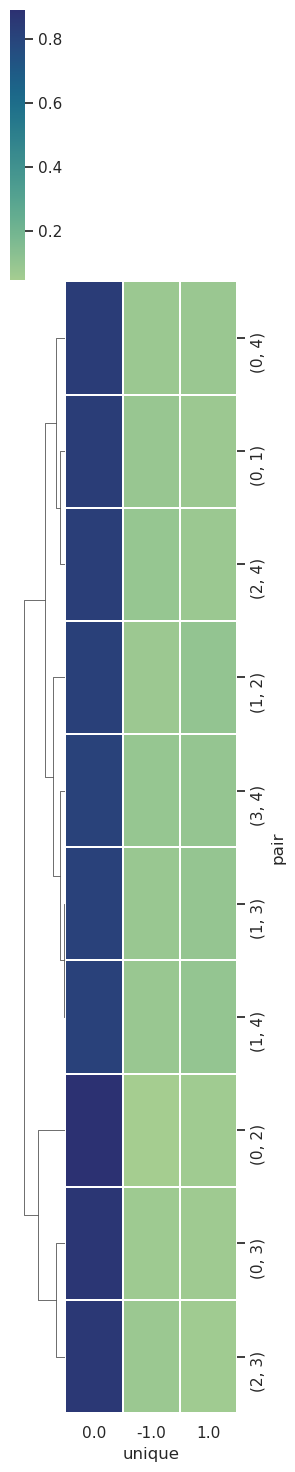

In [51]:
#concatenated_iters_comp

# use seaborn to plot the results, x-axis can be the pair and y-axis can be the value in the unique column 
g = sns.clustermap(concatenated_iters_comp_wide, cmap="crest", linewidth=.1, figsize=(3, 15), yticklabels=1)
g.ax_col_dendrogram.remove()

### Evaluate the learned posterions

The trial with the highest ELBO was 0
    unique    pair  percentage
4      0.0  (0, 2)    0.890201
7      0.0  (0, 3)    0.865329
10     0.0  (0, 4)    0.839339
1      0.0  (0, 1)    0.836281
The pair with the highest percentage overlap is (0, 2)
The highest percentage overlap across pairs was 0.89


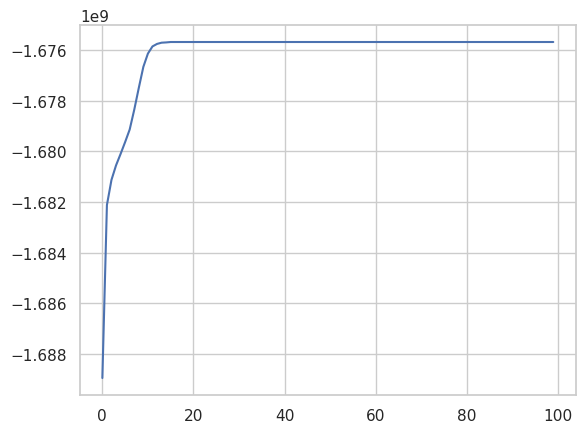

In [52]:
best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
print(f"The trial with the highest ELBO was {best}")

# print rows that contains best in the pair and only where unique == 0
best_res_comp = (concatenated_iters_comp[concatenated_iters_comp.pair.str.contains(str(best))])
print(best_res_comp[best_res_comp['unique'] == 0])

print(f"The pair with the highest percentage overlap is {concatenated_iters_comp.iloc[0].pair}")
print(f"The highest percentage overlap across pairs was {concatenated_iters_comp.iloc[0].percentage.round(3)}")

ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()

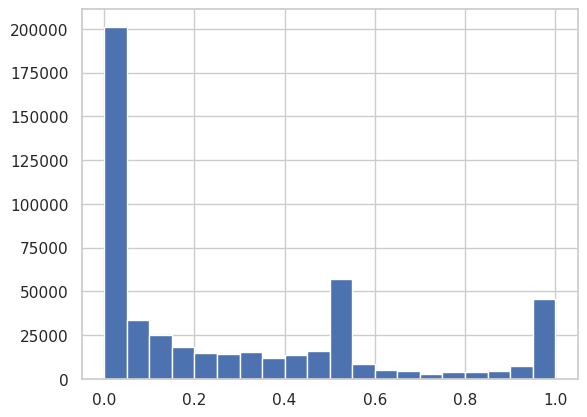

In [53]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)    
plt.hist(juncs_probs.cpu().numpy().flatten(), 20); plt.show()

In [54]:
theta_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
print(theta_f_plot_summ)

                                                           0         1  \
cell_id                                                                  
Brain_Myeloid_macrophage_pseudobulk                 0.016393  0.049180   
Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk    0.000000  0.025000   
Brain_Non-Myeloid_astrocyte_pseudobulk              0.004630  0.023148   
Brain_Non-Myeloid_brain_pericyte_pseudobulk         0.000000  0.000000   
Brain_Non-Myeloid_endothelial_cell_pseudobulk       0.006993  0.025175   
Brain_Non-Myeloid_neuron_pseudobulk                 0.010676  0.028470   
Brain_Non-Myeloid_oligodendrocyte_precursor_cel...  0.004926  0.029557   
Brain_Non-Myeloid_oligodendrocyte_pseudobulk        0.773189  0.033037   

                                                           2         3  \
cell_id                                                                  
Brain_Myeloid_macrophage_pseudobulk                 0.032787  0.360656   
Brain_Non-Myeloid_Bergmann_glial_cell

In [55]:
GAMMA_f

tensor([1230.,   99.,  269.,  146.,  468.,  289.,  698.,  271.])

In [56]:
np.random.dirichlet(GAMMA_f, 10)

array([[0.3510419 , 0.02666193, 0.0788654 , 0.04399973, 0.1427919 ,
        0.08235187, 0.1921944 , 0.08209287],
       [0.36133134, 0.02496471, 0.07470632, 0.03690446, 0.12374237,
        0.08607457, 0.21672983, 0.07554639],
       [0.348396  , 0.02966506, 0.07976367, 0.04561822, 0.13004509,
        0.08410256, 0.20435264, 0.07805676],
       [0.34136626, 0.02908569, 0.08359866, 0.04351444, 0.13886392,
        0.08291907, 0.19465295, 0.08599901],
       [0.35131895, 0.0326888 , 0.07875172, 0.03780786, 0.13235799,
        0.08118321, 0.20257704, 0.08331442],
       [0.3644677 , 0.02836518, 0.07316628, 0.04263593, 0.12571738,
        0.08277092, 0.19626426, 0.08661235],
       [0.35432284, 0.02968802, 0.08683033, 0.04086862, 0.13398913,
        0.08407892, 0.19596818, 0.07425398],
       [0.36234048, 0.02929727, 0.08302796, 0.03709144, 0.13161436,
        0.08748599, 0.196687  , 0.0724555 ],
       [0.35157674, 0.0302762 , 0.07391967, 0.0486626 , 0.12437276,
        0.08762096, 0.206784

In [57]:
GAMMA_f / GAMMA_f.sum()

tensor([0.3545, 0.0285, 0.0775, 0.0421, 0.1349, 0.0833, 0.2012, 0.0781])

In [58]:
# How much each cell state is used 
#latent proportions describe the general prevalence of each cluster in the datasetN
# cluster proportions via theta ~ dirichlet(GAMMA_f)
# each cell gets an assignment to a cluster via z_c | theta ~ categorical(theta)

theta = GAMMA_f / GAMMA_f.sum()
theta = theta.cpu().numpy()
theta_sorted = np.sort(theta)
theta_sorted

array([0.02853026, 0.04207493, 0.07752161, 0.07809798, 0.0832853 ,
       0.13487032, 0.20115274, 0.35446686], dtype=float32)

In [59]:
PHI_f #<- this is the matrix of probabilities of each cell belonging to each cluster

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

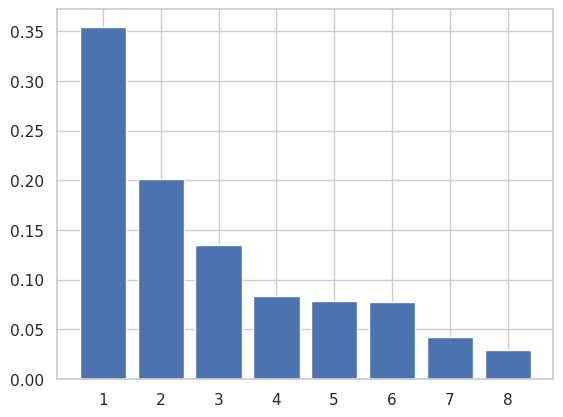

In [60]:
plt.bar(np.arange(K)+1,theta_sorted[::-1]); plt.show()

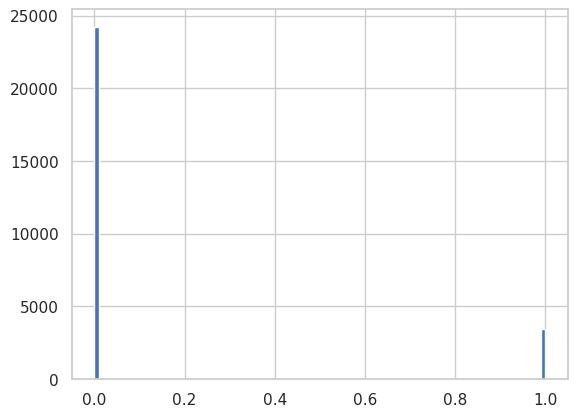

In [61]:
to_keep = theta > 0.01

x = PHI_f.cpu().numpy()
x = x[:,to_keep]
#x -= x.mean(1,keepdims=True)
#x /= x.std(1,keepdims=True)
_ = plt.hist(x.flatten(),100)

col_0                                                  0   1    2   3    4  \
cell_type                                                                    
Brain_Myeloid_macrophage_pseudobulk                    1   3    2  22   15   
Brain_Non-Myeloid_Bergmann_glial_cell_pseudobulk       0   1    3   3    9   
Brain_Non-Myeloid_astrocyte_pseudobulk                 2  10    8  20  366   
Brain_Non-Myeloid_brain_pericyte_pseudobulk            0   0    0   0    0   
Brain_Non-Myeloid_endothelial_cell_pseudobulk          5  18   14  11   13   
Brain_Non-Myeloid_neuron_pseudobulk                    3   8    8   3    9   
Brain_Non-Myeloid_oligodendrocyte_precursor_cel...     1   6  190   1    3   
Brain_Non-Myeloid_oligodendrocyte_pseudobulk        1217  52   43  85   52   

col_0                                                 5    6    7  
cell_type                                                          
Brain_Myeloid_macrophage_pseudobulk                  15    3    0  
Brain_Non-Myelo

<Figure size 1000x800 with 0 Axes>

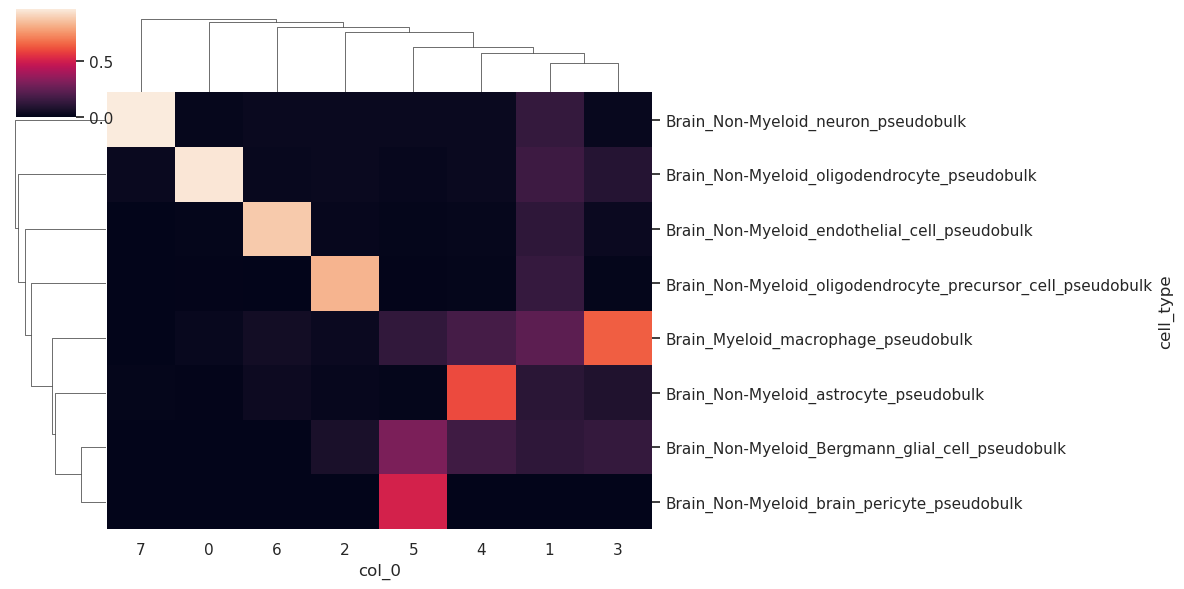

In [62]:
ct = pd.crosstab(cell_ids_conversion["cell_type"], x.argmax(axis=1) )
print(ct)

ct_np = ct.to_numpy()
print(ct_np)

ct_np = ct_np / ct_np.sum(1, keepdims=True) # normalize cell-type counts
print(ct_np)

ct_np = ct_np / ct_np.sum(0, keepdims=True)
print(ct_np)

ct.iloc[:,:] = ct_np

ax = plt.figure(figsize=[10,8])
sns.clustermap(ct, dendrogram_ratio=0.15, vmin = None, figsize=(12,6), annot = False)

In [63]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
# add "cell_state" to each column name 
juncs_probs_df.columns = ["cell_state_" + str(col) for col in juncs_probs_df.columns]
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values

def plot_juncObsUsage(junc_index):

    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]

    # get data for just junc_index 
    junc_dat=final_data[final_data.junction_id_index==junc_index]
    print(junc_dat.cell_type.value_counts())

    # make violin plot for junc_dat junction usage ratio coloured by cell_type and rotate plot 90 degrees
    plot = ggplot(junc_dat, aes(x='cell_type', y='juncratio', fill="cell_type")) + geom_violin() + geom_point() + plotnine.labels.ggtitle(junc_id) + plotnine.coords.coord_flip() 

    # add number of cells in each cell_type to plot 
    print(plot)

def plot_juncProbs(junc_index):
    
    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]
    
    # get data for just junc_index 
    junc_dat=juncs_probs_df[juncs_probs_df.junction_id_index==junc_index]
    junc_dat = junc_dat.melt().iloc[0:K]
    junc_dat.value = junc_dat.value.astype(float)
    # make violin plot for junc_dat junction usage ratio coloured by cell_type
    # don't print x-axis tick labels 
    plot = ggplot(junc_dat, aes(x='variable', y='value')) + geom_point() + theme(axis_text_x=element_blank())
    print(plot)

In [64]:
# calculate sd deviation for each junction for cell states 0 to 19 
juncs_probs_df["sd"] = juncs_probs_df.iloc[:,0:K].std(axis=1)

In [65]:
# write function that takes in cell state and returns top 10 junctions with the highest difference with all other K-1 cell states
def top10_juncs(cell_state):
    # for each junction get the difference between cell_state and all other cell states not including cell_state
    # return top 10 junctions with highest difference
    no_ref=juncs_probs_df[juncs_probs_df.columns[~juncs_probs_df.columns.isin([cell_state, "junction_id_index", "junction_id", "sd"])]]
    juncs_probs_df["diff"] = juncs_probs_df[cell_state] - no_ref.mean(axis=1)
    top10 = juncs_probs_df.sort_values(by="diff", ascending=False).head(10)
    return(top10.junction_id_index.values)

    # think of actually using the distributions... use the full beta distribution via KL divergence... (pairwise)
    # are the distributions across cell states for junctions more different than if they were coming from the same cell state

In [66]:
def log_beta(a, b):
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a + b)

def score(a, b):
    return log_beta(a,b).sum() - log_beta(a.sum(), b.sum())

In [67]:
juncs_probs[0, [0,9]]

IndexError: index 9 is out of bounds for dimension 0 with size 8

In [ ]:
# get likelihood ratio/bayes factor score for ALL junctions 
# let's compare just state 1 and 2 

scores_all_juncs = []
for junc_index in range(juncs_probs.shape[0]):
    a = ALPHA_f[junc_index, [0,9]]
    b = PI_f[junc_index, [0,9]]
    scores_all_juncs.append(score(a, b).item())

In [ ]:
# turn scores_all_juncs into dataframe and add junction_id_index as a column
scores_all_juncs_df = pd.DataFrame(scores_all_juncs, columns = ["score"])
scores_all_juncs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values

In [ ]:
scores_all_juncs_df.head()

In [ ]:
scores_all_juncs_df.sort_values(by="score", ascending=False).head(10)

In [ ]:
juncs_test=scores_all_juncs_df.sort_values(by="score", ascending=False).head(10).junction_id_index.values
juncs_test

In [ ]:
# make histogram of scores
scores_all_juncs_df.hist(column="score", bins=30)

In [ ]:
#top10juncs_state1 = top10_juncs("cell_state_9")
#top10juncs_state1

In [ ]:
# for each junction in top10juncs_state1, run plot_juncObsUsage and plot_juncProbs
for junc in juncs_test:
    plot_juncObsUsage(junc)
    plot_juncProbs(junc)